<a href="https://colab.research.google.com/github/5quark/Bear-classifier-/blob/master/Bear_classifier_not%20final%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --upgrade fastai

     |████████████████████████████████| 358kB 4.7MB/s 
     |████████████████████████████████| 40kB 4.9MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [53]:
import torch
from fastai.vision.all import *
from fastai.vision.widgets import *

# 1. Gathering the data

In [2]:
!pip install azure.cognitiveservices.search.imagesearch

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 40kB 6.3MB/s 
     |████████████████████████████████| 92kB 10.2MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 2.6MB 25.4MB/s 


In [3]:
!pip install msrest

In [5]:
import os
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth
def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

In [21]:
key = os.environ.get('AZURE_SEARCH_KEY', 'a2381ccb965e4c66b5177c43d8c8104e')
results = search_images_bing(key, 'grizzly bear') #here i searched grizzly bear 
ims = results.attrgot('content_url') #here i saved url's of 150 images. 
len(ims)
print(ims[0])

http://news.nationalgeographic.com/content/dam/news/2016/03/04/grizzly_delisting/01grizzlydelisting.ngsversion.1457364600397.jpg


In [28]:
os.mkdir("images") #here i created a directory called images and will dowload a image here to check it. 
os.path.abspath("images") #this one shows the path of the images directory to be able to locate it easily. 
os.listdir("images")  #this one lists the files in the directory called images.

[]

Let's create a path under images called grizzly.jpg, since this one is created in the images directory full directory is images/grizzly.jpg. Then use built in download_url() function which takes input ims[0], the first url from the ims list. and provide a full path to the image, this case called "dest".

In [30]:
dest = 'images/grizzly.jpg'
os.listdir("images")

['grizzly.jpg']

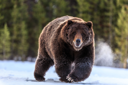

In [33]:
#Let's download one image and test it 
download_url(ims[0], dest) 
im = Image.open(dest)
im.to_thumb(128,128)

Next i need to download each individual image by using their urls.

In [35]:
#let's download all the images
bear_types="grizzly","black", "teddy"
path=Path("bears")
if not path.exists():
    path.mkdir()
    for i in bear_types:
        dest = (path/images)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{i} bear')
        download_images(dest, urls=results.attrgot('content_url'))

In [36]:
fns = get_image_files(path)
fns

(#435) [Path('bears/teddy/00000121.jpg'),Path('bears/teddy/00000061.jpg'),Path('bears/teddy/00000071.jpg'),Path('bears/teddy/00000077.jpg'),Path('bears/teddy/00000118.jpg'),Path('bears/teddy/00000124.jpg'),Path('bears/teddy/00000047.jpg'),Path('bears/teddy/00000006.jpg'),Path('bears/teddy/00000139.jpg'),Path('bears/teddy/00000098.jpg')...]

In [40]:
#There might be images that are failed to downloaded let's check:
failed = verify_images(fns)
failed

(#13) [Path('bears/teddy/00000028.jpg'),Path('bears/teddy/00000088.jpg'),Path('bears/teddy/00000094.jpg'),Path('bears/teddy/00000135.jpg'),Path('bears/black/00000112.jpg'),Path('bears/black/00000073.jpg'),Path('bears/black/00000105.jpg'),Path('bears/black/00000054.jpg'),Path('bears/grizzly/00000061.jpg'),Path('bears/grizzly/00000053.jpg')...]

In [ ]:
#There are 13 images that are failed to downloaded we need to remove them
failed.map(Path.unlink);

In [43]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))



* ***blocks*** is a tuple containing the types of dependent and independet variables. Here in this case independent variables are the images and dependent variables are the categories of bears (bear types).
* The get_image_files function takes a path, and returns a list of all of the images in that path. So ***get_items*** is a list containing all the paths.
*  I could split our data into to, the training set and validation set but i opted to do it randomly. Seed is here to make sure that the same photos are selected as a validation set everytime i run this notebook.
* Independent variables are usually referred as x and dependent variables as y. parent_label is a function provided by fastai that simply gets the name of the folder a file is in. Since previously i put each type of bear in different folders this will work. 
*Finally in the last step i resized each image. Since the model is not fed one image at a time not resizing can cause problems. 






Then we need to tell fastai the source of the data.

In [45]:
dls = bears.dataloaders(path)

# 2.Training

In [46]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [47]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.539262,0.212663,0.095238,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.215309,0.065305,0.011905,00:14
1,0.124547,0.072580,0.023810,00:14
2,0.085868,0.084028,0.023810,00:14
3,0.071139,0.085270,0.023810,00:15


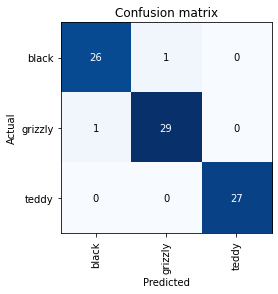

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

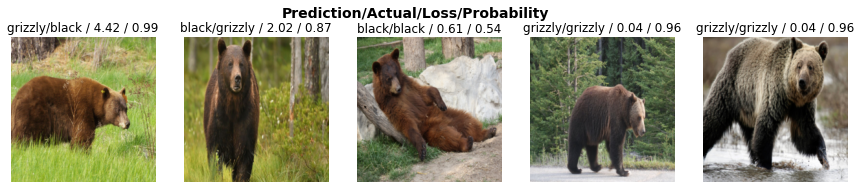

In [49]:
interp.plot_top_losses(5, nrows=1)

In [54]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [55]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()